## Super resolution

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_m = Path(root_dir + '/models') 
path_m.mkdir(parents=True, exist_ok=True)

In [0]:
#to save my model
#learn.path = Path(root_dir + '/models')
#??? model is stored with extension .pth '/content/gdrive/My Drive/models/models' 
#learn.save('m_1b')

In [4]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [7]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

resizing to 96 into /root/.fastai/data/oxford-iiit-pet/small-96


resizing to 256 into /root/.fastai/data/oxford-iiit-pet/small-256


In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

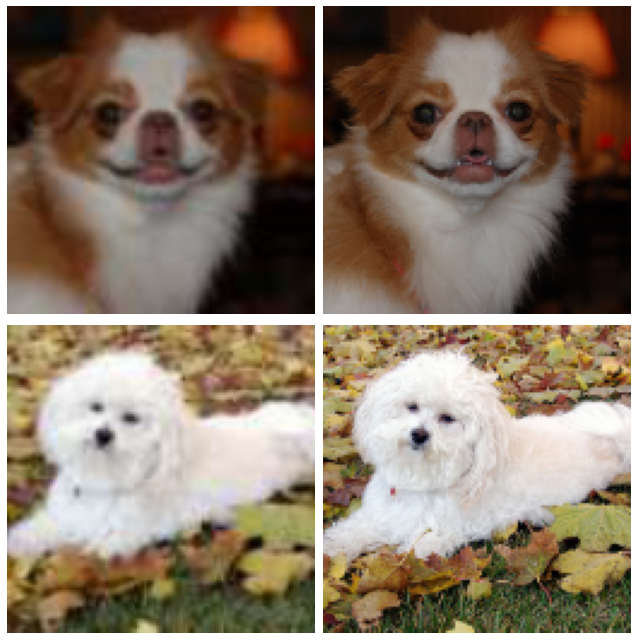

In [0]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
#data.valid_ds[0][1].shape
t.shape

torch.Size([2, 3, 128, 128])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [13]:
gram_matrix(t)

tensor([[[0.1049, 0.0873, 0.0675],
         [0.0873, 0.0735, 0.0578],
         [0.0675, 0.0578, 0.0467]],

        [[0.1049, 0.0873, 0.0675],
         [0.0873, 0.0735, 0.0578],
         [0.0675, 0.0578, 0.0467]]])

In [0]:
base_loss = F.l1_loss

In [15]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [16]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [19]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


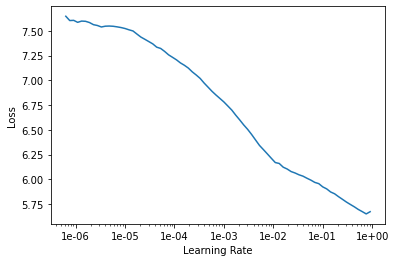

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(path_m/save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.888084,3.695946,0.140012,0.227525,0.315934,0.224417,0.538969,1.205431,1.043659,04:21
1,3.855757,3.718312,0.141147,0.226581,0.315925,0.225101,0.555374,1.203476,1.050708,04:16
2,3.743518,3.559064,0.131559,0.220908,0.305033,0.217866,0.510490,1.151461,1.021747,04:13


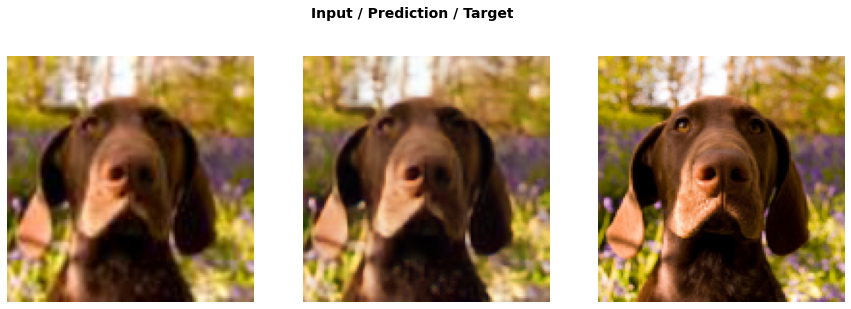

In [0]:
#a1 = do_fit('1a', slice(lr*10))
do_fit('1a', slice(lr*10))

In [0]:
learn.load(path_m/'1a')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dil

In [0]:
learn.save('a1')


with open(path_m/'a1.pth', 'w') as f:
  f.write('content')
#learn.path

In [0]:
with open(path_m/'a1.pth', 'rb') as pickled:
  data=pickle.load(pickled)

In [0]:
learn.load(path_m/'m_1b')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dil

In [0]:
path_m.ls()

[PosixPath('/content/gdrive/My Drive/models/models'),
 PosixPath('/content/gdrive/My Drive/models/a1.pth')]

In [0]:
save_name = 'b1_try'
#root_dir = "/content/gdrive/My Drive/"
path = F"/content/gdrive/My Drive/{save_name}" 
learn.load('1b')

In [0]:
#path = Path(root_dir + '/models')
#learn.export(file = 'export_clas.pkl')

In [0]:
#Create directory to save model
dest=Path(base_dir + "models/folder_name/")
try:

  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

In [0]:
#Save it
learn.save(dest/'stage-1')

In [0]:
model1 = load_learner(path=path_m, fname='a1.pth')
#model1 = load_data(path=path_m, fname=“a1.pth”)

In [0]:
learn.unfreeze()

In [0]:
save_name = '1a_try'
#root_dir = "/content/gdrive/My Drive/"
path = F"/content/gdrive/My Drive/{save_name}" 
torch.save(learn, path)#.state_dict(), path)

In [0]:
model_save_name = '1a'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.764618,3.607208,0.128977,0.221558,0.306664,0.220138,0.531850,1.168664,1.029358,04:05
1,3.750958,3.595649,0.129769,0.221497,0.306320,0.219568,0.526534,1.164420,1.027542,04:05
2,3.751806,3.587699,0.129217,0.221285,0.306083,0.219255,0.524177,1.162299,1.025382,04:05
3,3.743192,3.577156,0.128716,0.220678,0.304739,0.218617,0.522446,1.159134,1.022826,04:05
4,3.723626,3.564289,0.128089,0.220685,0.304299,0.218177,0.517088,1.155140,1.020812,04:05


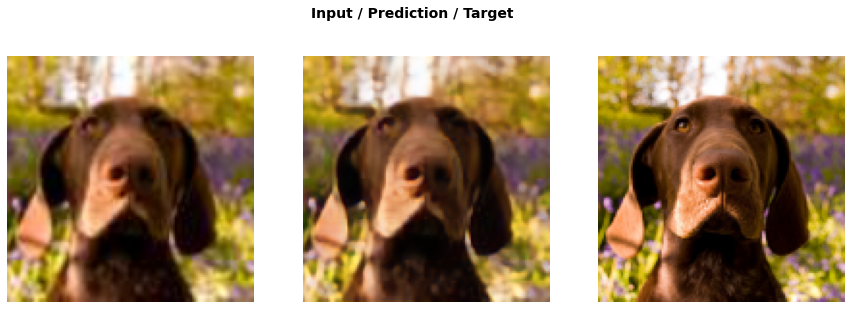

In [0]:
b1 = do_fit('1b', slice(1e-5,lr))

In [0]:
save_name = 'b1_try'
#root_dir = "/content/gdrive/My Drive/"
path = F"/content/gdrive/My Drive/{save_name}" 
torch.save(b1, path)#.state_dict(), path)

PosixPath('/content/gdrive/My Drive/models')

In [0]:



save_name = 'b1_try'
#root_dir = "/content/gdrive/My Drive/"
path = F"/content/gdrive/My Drive/{save_name}" 
learn.load('1b')

In [0]:
data = get_data(12,size*2)

In [0]:
learn.data = data
learn.freeze()
gc.collect()

70

In [0]:
#learn.load('1b');
learn.load(path_m/'m_1b');

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.234431,2.201225,0.159023,0.257840,0.294946,0.154117,0.383029,0.587888,0.364381,18:18
1,2.192790,2.177033,0.160012,0.259358,0.293955,0.153734,0.368852,0.580188,0.360934,17:48
2,2.180146,2.157829,0.160252,0.257664,0.290844,0.151517,0.366658,0.573844,0.357051,17:49
3,2.149243,2.131514,0.160329,0.257760,0.289281,0.150588,0.355423,0.564126,0.354008,17:50
4,2.142986,2.131294,0.162380,0.257057,0.288037,0.149090,0.355778,0.566877,0.352075,17:49
5,2.123514,2.112414,0.161813,0.255175,0.286318,0.148682,0.350725,0.559057,0.350644,17:46
6,2.101512,2.098381,0.161964,0.256132,0.285890,0.147815,0.342994,0.554192,0.349395,17:44
7,2.102337,2.088231,0.162648,0.255410,0.285134,0.147405,0.337711,0.552793,0.347129,17:47
8,2.078668,2.084405,0.162158,0.254630,0.282961,0.146362,0.340773,0.551944,0.345577,17:53
9,2.066643,2.061711,0.162108,0.254626,0.282755,0.146222,0.328738,0.543258,0.344003,17:52


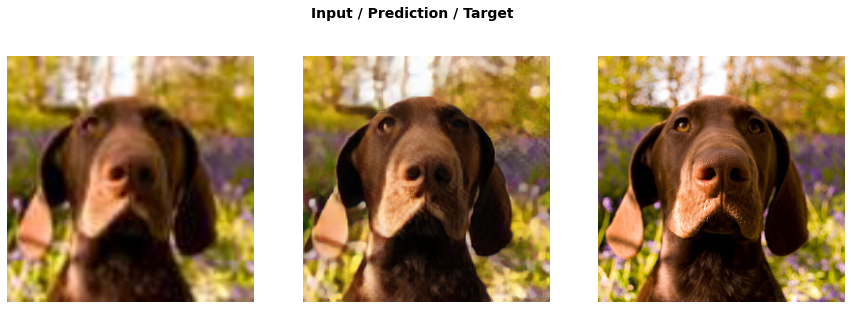

In [0]:
do_fit('2a')

In [0]:
#learn.path = Path(root_dir + '/models')
#??? model is stored with extension .pth '/content/gdrive/My Drive/models/models' 
#learn.save('m_1b')

In [0]:
learn.load(path_m/'2a');

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.400584,3.229797,0.137476,0.222531,0.290770,0.192205,0.442192,1.064116,0.880508,02:44
1,3.332982,3.134432,0.133010,0.217411,0.282474,0.185546,0.429867,1.035380,0.850744,02:38
2,3.292443,3.083372,0.131531,0.215165,0.278504,0.182274,0.421200,1.018991,0.835706,02:39
3,3.263851,3.064239,0.130253,0.213972,0.276480,0.181040,0.419488,1.013104,0.829902,02:39
4,3.252276,3.050263,0.129723,0.212968,0.275344,0.180129,0.417919,1.008428,0.825752,02:39
5,3.245453,3.038811,0.130097,0.212955,0.274798,0.179588,0.413773,1.004660,0.822939,02:38
6,3.245318,3.033417,0.130204,0.212757,0.274543,0.179249,0.412377,1.003011,0.821276,02:39
7,3.247095,3.031764,0.129799,0.212546,0.274226,0.179105,0.412753,1.002585,0.820748,02:39
8,3.225667,3.032445,0.129686,0.212446,0.274225,0.179121,0.413080,1.002896,0.820990,02:39
9,3.229634,3.031595,0.129626,0.212318,0.274124,0.179074,0.413184,1.002483,0.820786,02:40


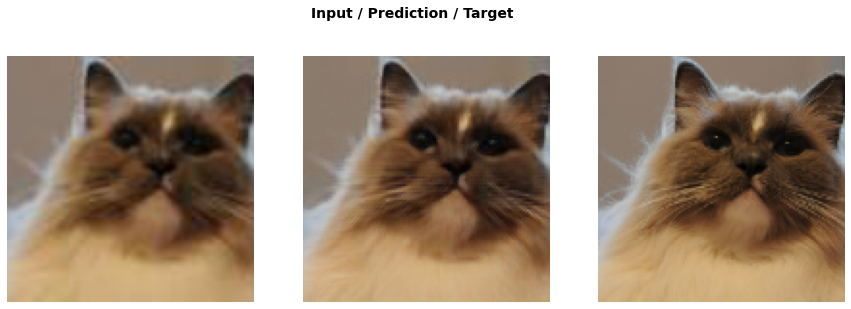

In [25]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [0]:
learn = None
gc.collect();

In [27]:
256/320*1024

819.2

In [0]:
256/320*1600

1280.0

In [28]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(820, 1024), have 6968MB of GPU RAM free


In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load(path_m/'2b');#learn.load('2b');

In [0]:
learn.data = data_mr

In [33]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/root/.fastai/data/oxford-iiit-pet/small-256/Ragdoll_170.jpg')

In [34]:
img = open_image(fn); img.shape

torch.Size([3, 256, 385])

In [0]:
p,img_hr,b = learn.predict(img)

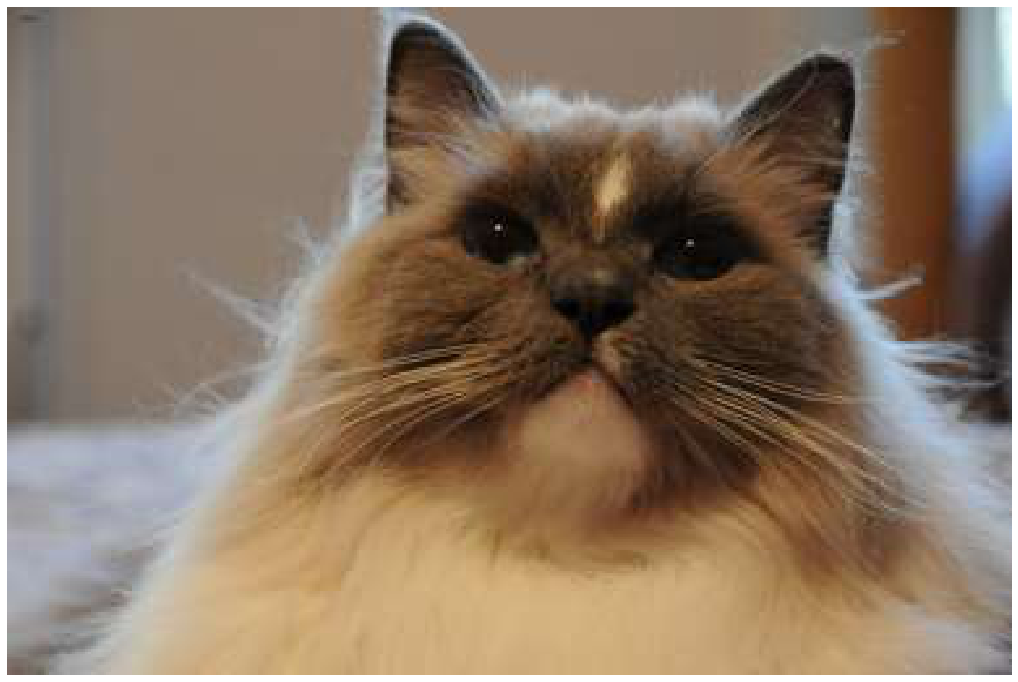

In [36]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


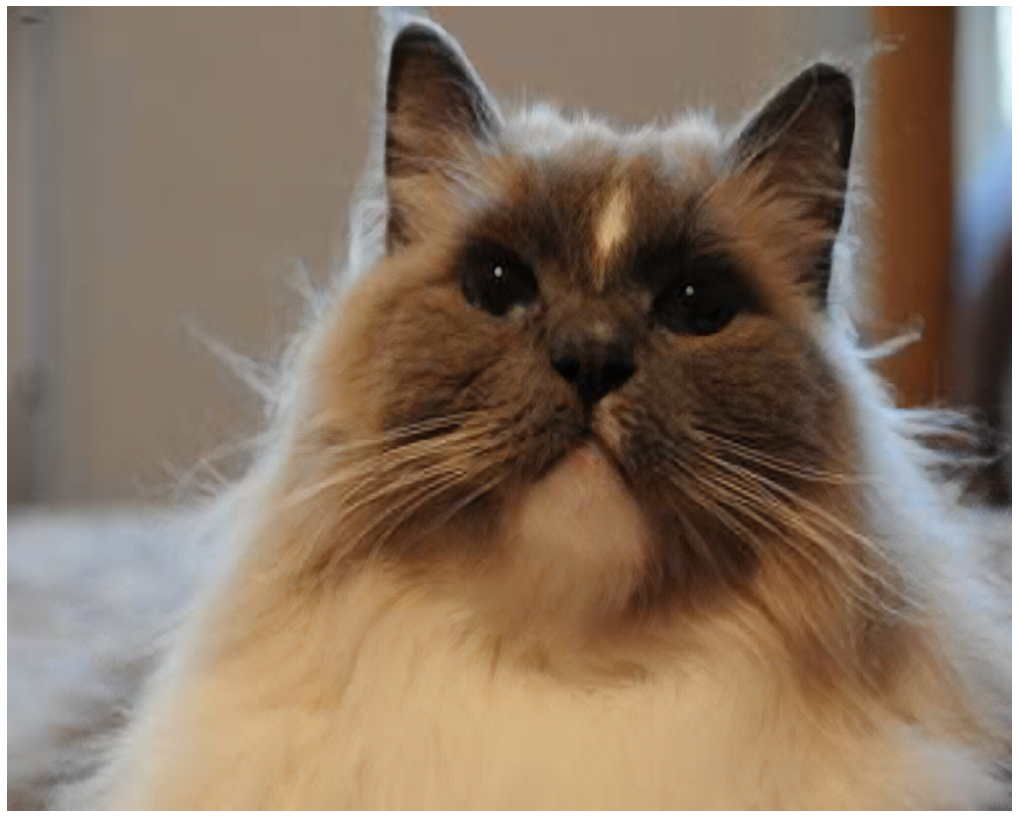

In [37]:
Image(img_hr).show(figsize=(18,15))